In [12]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [13]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
model_json_path = 'model/keypoint_classifier/json'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [14]:
NUM_CLASSES = 8

# Dataset reading

In [15]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [16]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [19]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1376      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
Total params: 2040 (7.97 KB)
Trainable params: 2040 (7.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [21]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [22]:
history = model.fit(
    X_train,
    y_train,
    epochs=1500,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1500


 1/24 [>.............................] - ETA: 14s - loss: 2.1802 - accuracy: 0.0859
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 1s 10ms/step - loss: 2.2311 - accuracy: 0.0923 - val_loss: 2.0925 - val_accuracy: 0.1219
Epoch 2/1500
 1/24 [>.............................] - ETA: 0s - loss: 2.1738 - accuracy: 0.1406
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 4ms/step - loss: 2.1959 - accuracy: 0.1190 - val_loss: 2.0641 - val_accuracy: 0.1469
Epoch 3/1500
 1/24 [>.............................] - ETA: 0s - loss: 2.2843 - accuracy: 0.0859
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 4ms/step - loss: 2.1712 - accuracy: 0.1203 - val_loss: 2.0406 - val_accuracy: 0.1618
Epoch 4/1500
 1/24 [>.............................] - ETA: 0s - loss: 2.1259 - accuracy: 0.1641
Epoch 4: sav

In [23]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 2ms/step - loss: 0.2301 - accuracy: 0.9500


In [24]:
# Loading the saved model
# model = tf.keras.models.load_model(model_save_path)

In [25]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 86ms/step
[4.1712341e-03 9.7671014e-01 7.2384402e-03 5.6288689e-03 3.9910392e-05
 5.6663540e-04 5.6234957e-03 2.1253289e-05]
1


# Confusion matrix

32/32 [==============================] - 0s 978us/step


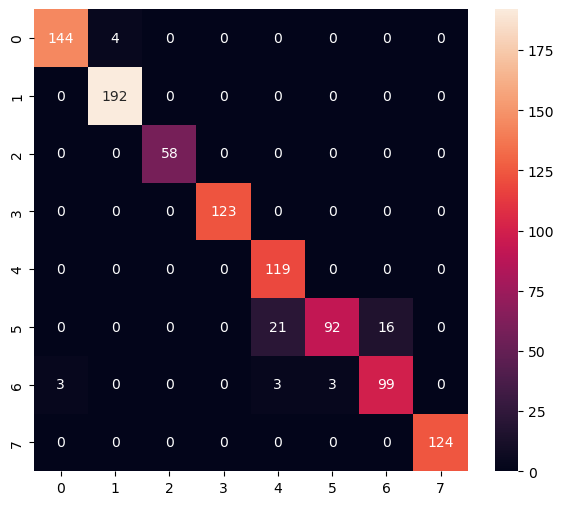

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       148
           1       0.98      1.00      0.99       192
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00       123
           4       0.83      1.00      0.91       119
           5       0.97      0.71      0.82       129
           6       0.86      0.92      0.89       108
           7       1.00      1.00      1.00       124

    accuracy                           0.95      1001
   macro avg       0.95      0.95      0.95      1001
weighted avg       0.95      0.95      0.95      1001



In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

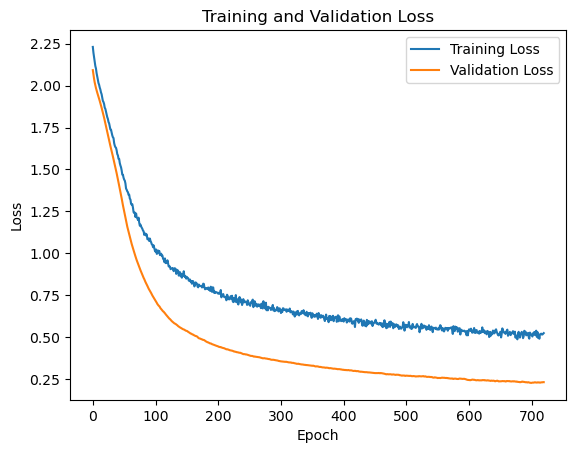

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

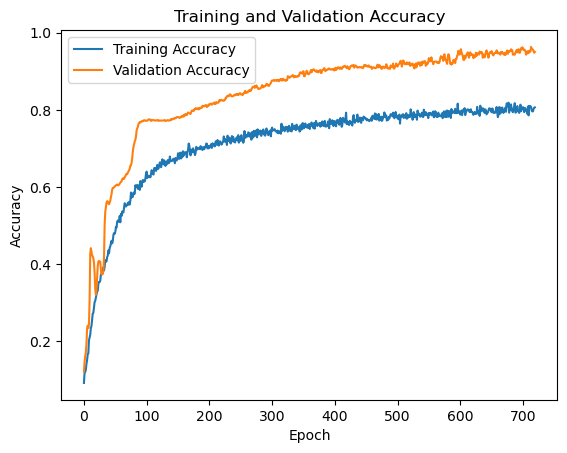

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Convert to model for Tensorflow-Lite

In [29]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=True)

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpwz76luyd\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpwz76luyd\assets


6344

# Inference test

In [31]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [32]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [33]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [34]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms
